In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from typing import Optional, Tuple, Union
from ot import emd2_1d
from dem.models.components.optimal_transport import wasserstein
from dem.utils.data_utils import remove_mean
from dem.utils.logging_utils import fig_to_image

In [2]:
import sys
sys.path.append('..')


In [3]:
from dem.energies.multi_double_well_energy import MultiDoubleWellEnergy
from dem.energies.lennardjones_energy import LennardJonesPotential, LennardJonesEnergy

In [4]:
energy= LennardJonesEnergy(
            dimensionality= 165,
            n_particles= 55,
            data_path= "../data/test_split_LJ55-1000-part1.npy",
            data_path_train= "../data/train_split_LJ55-1000-part1.npy",
            data_path_val= "../data/val_split_LJ55-1000-part1.npy",
            device='cpu',
            data_normalization_factor= 1.0,
            is_molecule= True)

In [5]:
def _calc_dist_total_var(
    gt_samples: torch.Tensor,
    latest_samples: torch.Tensor,
    system_shape: Union[torch.Size, Tuple[int]],
    energy_function    ) -> torch.Tensor:
    x = gt_samples.view(*system_shape)
    y = latest_samples.view(*system_shape) if latest_samples.device == "cpu" else latest_samples.detach().cpu().view(*system_shape)
    
    if x.size(-1) == 3:
        generated_samples_dists = (
            energy_function.interatomic_dist(x).cpu().numpy().reshape(-1),
        )
        data_set_dists = energy_function.interatomic_dist(y).cpu().numpy().reshape(-1)

        H_data_set, x_data_set = torch.histogram(data_set_dists, bins=200)
        H_generated_samples, _ = torch.histogram(generated_samples_dists, bins=(x_data_set))
        total_var = (
            0.5
            * torch.abs(
                H_data_set / H_data_set.sum() - H_generated_samples / H_generated_samples.sum()
            ).sum()
        )
    else:
        H_data_set_x, x_data_set = torch.histogram(x[:, 0], bins=200)
        H_data_set_y, _ = torch.histogram(x[:, 1], bins=(x_data_set))
        H_generated_samples_x, _ = torch.histogram(y[:, 0], bins=(x_data_set))
        H_generated_samples_y, _ = torch.histogram(y[:, 1], bins=(x_data_set))
        total_var = (
            0.5
            * (
                torch.abs(
                    H_data_set_x / H_data_set_x.sum() - H_generated_samples_x / H_generated_samples_x.sum()
                ) +
                torch.abs(
                    H_data_set_y / H_data_set_y.sum() - H_generated_samples_y / H_generated_samples_y.sum()
                )
            ).sum()
        )
    return total_var

def get_hist_metrics(samples,test,prefix="",range=(0,7)):
    metrics={}
    samples_hist,_=np.histogram(samples.view(-1),bins=100,density=True,range=range)
    test_hist,_=np.histogram(test.view(-1),bins=100,density=True,range=range)
    #w2 distance
    w2=emd2_1d(samples.view(-1),test.view(-1),metric="euclidean")
    #l2 distance
    l2_distance = np.linalg.norm(samples_hist - test_hist)
    metrics[prefix+"L2 Distance"]=l2_distance
    metrics[prefix+"W2 Distance"]=w2
    return metrics

def compute_metrics(energy,initial_samples,test_set,plot_figs=True):
    log_metrics={}
    current_samples_idx=torch.multinomial(torch.ones(initial_samples.size()[0]),test_set.size()[0], replacement=False)
    current_samples=initial_samples[current_samples_idx]
    if energy.is_molecule:
        current_samples=remove_mean(current_samples,energy.n_particles,energy.n_spatial_dim)
        test_set=remove_mean(test_set,energy.n_particles,energy.n_spatial_dim)
        dist_samples = energy.interatomic_dist(current_samples).detach().cpu()
        dist_test = energy.interatomic_dist(test_set).detach().cpu()
        
        dist_metrics=get_hist_metrics(dist_samples,dist_test,prefix="Interatomic Distance ",range=(0,7))
        if energy.n_particles == 13:
            min_energy = -60
            max_energy = 0
        elif energy.n_particles == 55:
            min_energy = -380
            max_energy = -180
        else:
            min_energy = -26
            max_energy = 0
        energy_samples = -energy(current_samples).detach().cpu()
        energy_test = -energy(test_set).detach().cpu()
        energy_metrics=get_hist_metrics(energy_samples,energy_test,prefix="Energy ",range=(min_energy,max_energy))
        log_metrics.update(dist_metrics)
        log_metrics.update(energy_metrics)
    current_samples=current_samples.cpu()
    test_set=test_set.cpu()
    w2=wasserstein(test_set,current_samples,power=2)
    tv=_calc_dist_total_var(test_set,current_samples,current_samples.shape,energy)
    log_metrics["W2"]=w2
    log_metrics["Total Variation"]=tv
    return log_metrics
    


In [6]:
dataset=np.load("../lj55_long_3.npy")
print(dataset.shape)
np.random.seed(0)
dataset=np.random.permutation(dataset)
test_set=dataset[:1000]
dataset=dataset[1000:]
print(test_set.shape)
np.save("../test_lj55_long-1000.npy",test_set)

(12800, 165)
(1000, 165)


In [7]:
torch_dataset=torch.tensor(dataset)
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]

for i in tqdm.tqdm(range(25)):
    current_samples_idx=torch.multinomial(torch.ones(torch_dataset.shape[0]),torch_test_set.shape[0], replacement=False)
    current_samples=torch_dataset[current_samples_idx]
    metrics=compute_metrics(energy,current_samples,torch_test_set)
    w2s.append(metrics["W2"])
    tvs.append(metrics["Total Variation"])
    energy_l2s.append(metrics["Energy L2 Distance"])
    energy_w2s.append(metrics["Energy W2 Distance"])
    interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
    interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])


100%|██████████| 25/25 [00:45<00:00,  1.84s/it]


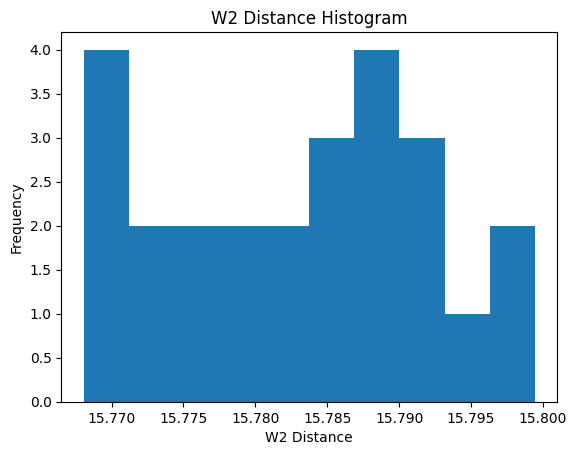

W2 Distance Mean:  15.783121149209167
W2 Distance Std:  0.009233592737517312


In [8]:
plt.figure()
plt.hist(w2s,bins=10)
plt.xlabel("W2 Distance")
plt.ylabel("Frequency")
plt.title("W2 Distance Histogram")
plt.show()

print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))

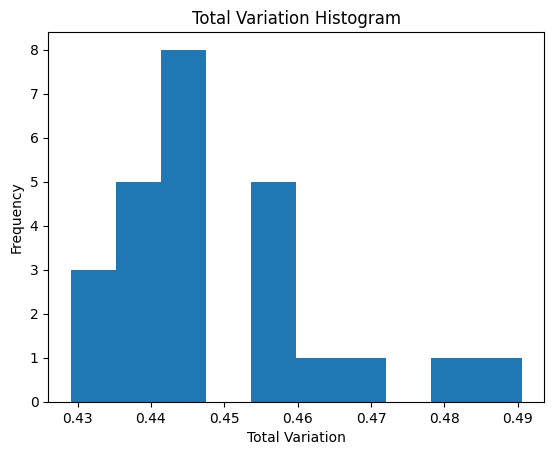

Total Variation Mean:  0.44948617
Total Variation Std:  0.014968211


In [9]:
plt.figure()
plt.hist(tvs,bins=10)
plt.xlabel("Total Variation")
plt.ylabel("Frequency")
plt.title("Total Variation Histogram")
plt.show()

print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))

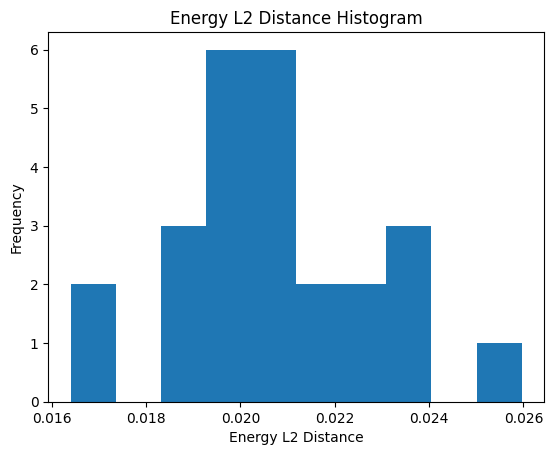

Energy L2 Distance Mean:  0.02065364402432266
Energy L2 Distance Std:  0.0021135251397986915


In [10]:
plt.figure()
plt.hist(energy_l2s,bins=10)
plt.xlabel("Energy L2 Distance")
plt.ylabel("Frequency")
plt.title("Energy L2 Distance Histogram")
plt.show()

print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))

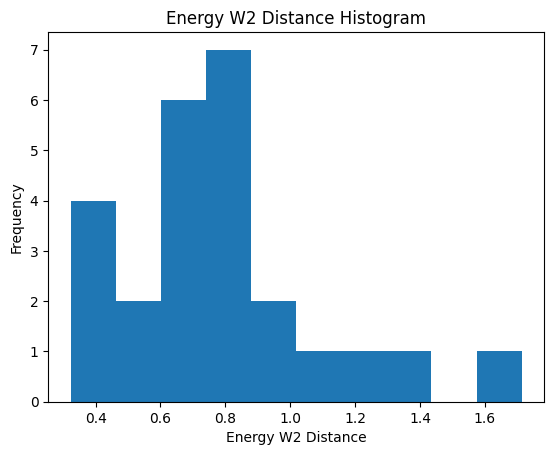

Energy W2 Distance Mean:  0.77511007
Energy W2 Distance Std:  0.30984554


In [11]:
plt.figure()
plt.hist(energy_w2s,bins=10)
plt.xlabel("Energy W2 Distance")
plt.ylabel("Frequency")
plt.title("Energy W2 Distance Histogram")
plt.show()

print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))

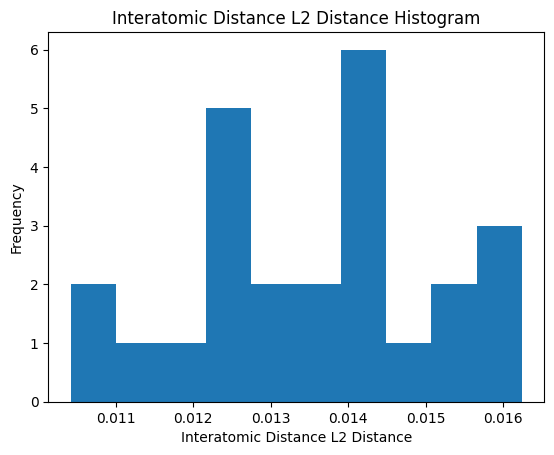

Interatomic Distance L2 Distance Mean:  0.013579599837183043
Interatomic Distance L2 Distance Std:  0.0015968653840444842


In [12]:
plt.figure()
plt.hist(interatomic_l2s,bins=10)
plt.xlabel("Interatomic Distance L2 Distance")
plt.ylabel("Frequency")
plt.title("Interatomic Distance L2 Distance Histogram")
plt.show()

print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))

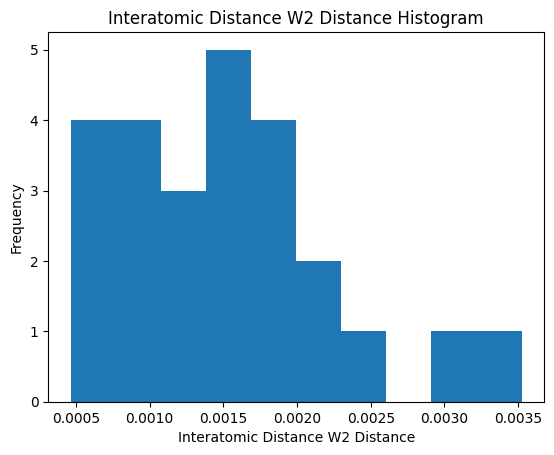

Interatomic Distance W2 Distance Mean:  0.0014954747
Interatomic Distance W2 Distance Std:  0.0007370741


In [13]:
plt.figure()
plt.hist(interatomic_w2s,bins=10)
plt.xlabel("Interatomic Distance W2 Distance")
plt.ylabel("Frequency")
plt.title("Interatomic Distance W2 Distance Histogram")
plt.show()

print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

long simulation endpoint vs current reference

In [14]:
simulation_dataset=np.load("../lj55_long.npy")
torch_simulation_dataset=torch.tensor(simulation_dataset)
test_set=np.load("../data/test_split_LJ55-1000-part1.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in tqdm.tqdm(range(25)):
    current_samples_idx=torch.multinomial(torch.ones(torch_simulation_dataset.shape[0]),torch_test_set.shape[0], replacement=False)
    current_samples=torch_simulation_dataset[current_samples_idx]
    metrics=compute_metrics(energy,current_samples,torch.tensor(test_set))
    w2s.append(metrics["W2"])
    tvs.append(metrics["Total Variation"])
    energy_l2s.append(metrics["Energy L2 Distance"])
    energy_w2s.append(metrics["Energy W2 Distance"])
    interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
    interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

100%|██████████| 25/25 [00:42<00:00,  1.69s/it]

W2 Distance Mean:  15.92385115113483
W2 Distance Std:  0.006864375515320778
Total Variation Mean:  0.4646243
Total Variation Std:  0.016541135
Energy L2 Distance Mean:  0.024314549299528365
Energy L2 Distance Std:  0.0027427526977116473
Energy W2 Distance Mean:  0.89787465
Energy W2 Distance Std:  0.22822964
Interatomic Distance L2 Distance Mean:  0.01809044793552407
Interatomic Distance L2 Distance Std:  0.001789299321193311
Interatomic Distance W2 Distance Mean:  0.0014067075
Interatomic Distance W2 Distance Std:  0.0005441192


short simulation endpoints vs current reference

In [15]:
test_set=np.load("../data/test_split_LJ55-1000-part1.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../lj55_endpoint{}.npy'.format(i)
    endpoint_samples=np.load(endpoint)
    torch_endpoint_samples=torch.tensor(endpoint_samples)
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

W2 Distance Mean:  16.48329524530761
W2 Distance Std:  0.04594580536103766
Total Variation Mean:  0.7443799
Total Variation Std:  0.13166915
Energy L2 Distance Mean:  0.023298112818433716
Energy L2 Distance Std:  0.0021949804326085623
Energy W2 Distance Mean:  0.8497774
Energy W2 Distance Std:  0.21566358
Interatomic Distance L2 Distance Mean:  0.017630826783029508
Interatomic Distance L2 Distance Std:  0.001745592945116942
Interatomic Distance W2 Distance Mean:  0.0012578074
Interatomic Distance W2 Distance Std:  0.00039689348


short simulation endpoints vs new reference

In [16]:
test_set=np.load("../test_lj55_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../lj55_endpoint{}.npy'.format(i)
    endpoint_samples=np.load(endpoint)
    torch_endpoint_samples=torch.tensor(endpoint_samples)
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

W2 Distance Mean:  16.425741997231093
W2 Distance Std:  0.025137870679625068
Total Variation Mean:  0.7509951
Total Variation Std:  0.14005172
Energy L2 Distance Mean:  0.019470073515991292
Energy L2 Distance Std:  0.002652590673642372
Energy W2 Distance Mean:  0.8692409
Energy W2 Distance Std:  0.30602565
Interatomic Distance L2 Distance Mean:  0.014086085424935928
Interatomic Distance L2 Distance Std:  0.0018216377673995082
Interatomic Distance W2 Distance Mean:  0.0016705148
Interatomic Distance W2 Distance Std:  0.000688488


IDEM vs current reference

In [19]:
test_set=np.load("../data/test_split_LJ55-1000-part1.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,4):
    endpoint='../IDEM_samples/LJ55_{}_samples_10000.pt'.format(i)
    torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
    for j in range(8):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

/tmp/ipykernel_2506259/3349700123.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


W2 Distance Mean:  16.1430801701165
W2 Distance Std:  0.12177376536327256
Total Variation Mean:  0.45601925
Total Variation Std:  0.012706967
Energy L2 Distance Mean:  0.0833442406565269
Energy L2 Distance Std:  0.04099222547492301
Energy W2 Distance Mean:  21.70402
Energy W2 Distance Std:  15.174306
Interatomic Distance L2 Distance Mean:  0.4194615774452199
Interatomic Distance L2 Distance Std:  0.07385993495433013
Interatomic Distance W2 Distance Mean:  0.08479455
Interatomic Distance W2 Distance Std:  0.033331778


IDEM vs new reference

In [20]:
test_set=np.load("../test_lj55_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,4):
    endpoint='../IDEM_samples/LJ55_{}_samples_10000.pt'.format(i)
    torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
    for j in range(4):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

/tmp/ipykernel_2506259/662102677.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


W2 Distance Mean:  16.054009177992725
W2 Distance Std:  0.12527718363652418
Total Variation Mean:  0.45836484
Total Variation Std:  0.014270357
Energy L2 Distance Mean:  0.08242611827409871
Energy L2 Distance Std:  0.0443078438458056
Energy W2 Distance Mean:  21.530996
Energy W2 Distance Std:  15.314459
Interatomic Distance L2 Distance Mean:  0.4147161012106926
Interatomic Distance L2 Distance Std:  0.07360799064086493
Interatomic Distance W2 Distance Mean:  0.08453614
Interatomic Distance W2 Distance Std:  0.033571318


Interatomic distance distribution

In [22]:
test_set=np.load("../data/test_split_LJ55-1000-part1.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
dist_current_reference = energy.interatomic_dist(torch_test_set).detach().cpu()
test_set=np.load("../test_lj55_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
dist_new_reference = energy.interatomic_dist(torch_test_set).detach().cpu()
endpoint='../lj55_endpoint1.npy'
endpoint_samples=np.load(endpoint)
torch_endpoint_samples=torch.tensor(endpoint_samples)
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
dist_mcmc_reference = energy.interatomic_dist(current_samples).detach().cpu()
endpoint='../IDEM_samples/LJ55_1_samples_10000.pt'
torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
dist_idem_reference = energy.interatomic_dist(current_samples).detach().cpu()

/tmp/ipykernel_2506259/2841505720.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


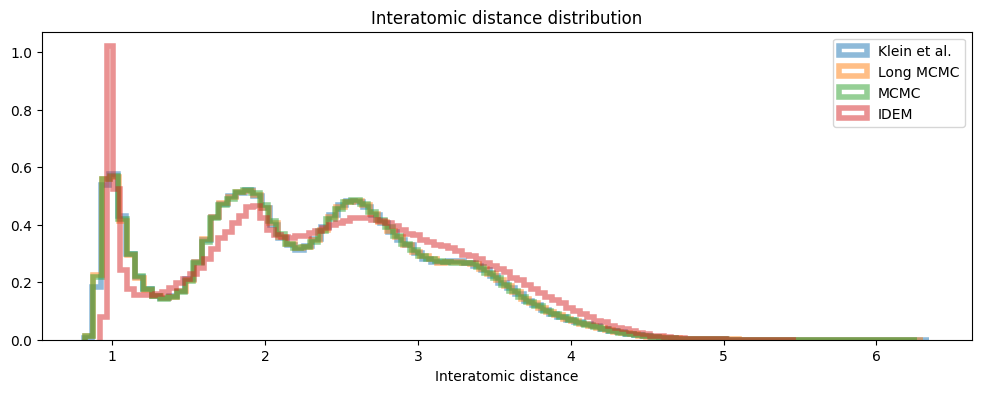

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.hist(
        dist_current_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.hist(
        dist_new_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.hist(
        dist_mcmc_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.hist(
        dist_idem_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.set_xlabel("Interatomic distance")
ax.legend(["Klein et al.", "Long MCMC", "MCMC", "IDEM"])
ax.set_title("Interatomic distance distribution")
figure=fig_to_image(fig)
figure.save("lj55_interatomic_distance_distribution.png")

Energy distribution

In [24]:
test_set=np.load("../data/test_split_LJ55-1000-part1.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
energy_current_reference = -energy(torch_test_set).detach().cpu()
test_set=np.load("../test_lj55_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
energy_new_reference = -energy(torch_test_set).detach().cpu()
endpoint='../lj55_endpoint1.npy'
endpoint_samples=np.load(endpoint)
torch_endpoint_samples=torch.tensor(endpoint_samples)
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
energy_mcmc_reference = -energy(current_samples).detach().cpu()
endpoint='../IDEM_samples/LJ55_1_samples_10000.pt'
torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
energy_idem_reference = -energy(current_samples).detach().cpu()

/tmp/ipykernel_2506259/3334898310.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


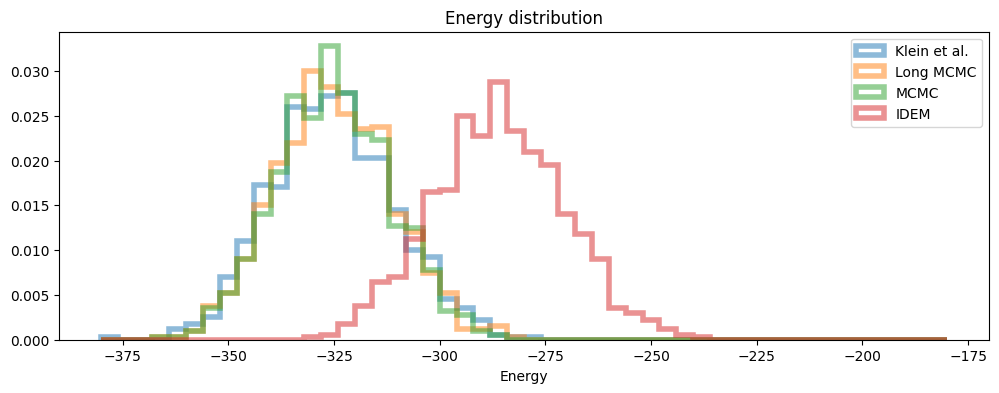

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
min_energy = -380
max_energy = -180
ax.hist(
        energy_current_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.hist(
        energy_new_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.hist(
        energy_mcmc_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.hist(
        energy_idem_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.set_xlabel("Energy")
ax.legend(["Klein et al.", "Long MCMC", "MCMC", "IDEM"])
ax.set_title("Energy distribution")
figure=fig_to_image(fig)
figure.save("lj55_energy_distribution.png")